In [0]:
import time
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import csv
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
%matplotlib inline

In [0]:
def register_extension(id, extension):
    Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
import requests

def send_image_to_slack(img_path, token, channel, file_name, comment, title):
    files = {'file': open(img_path, 'rb')}
    param = {
        'token': token,
        'channels': channel,
        'filename': file_name,
        'initial_comment': comment,
        'title': title
    }
    requests.post(
        url="https://slack.com/api/files.upload", params=param, files=files)

In [0]:
def get_noise_from_uniform(batch_size=1,
                           input_dim=100,
                           convert_tensor=False,
                           low=-1,
                           high=1):
    noise_z = np.random.uniform(
        low, high, size=[batch_size, input_dim]).astype(np.float32)
    if (convert_tensor):
        noise_z = torch.from_numpy(noise_z)
    return noise_z

In [0]:
class Generator(nn.Module):
 
    def __init__(self):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1)
        #self.conv1 = nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1)
        self.conv1_bn = nn.BatchNorm2d(128)
        self.conv2 = nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1)
        #self.conv2 = nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.ConvTranspose2d(64,1,kernel_size=4,stride=2,padding=1)
        #self.conv3 = nn.Conv2d(64,1,kernel_size=3,stride=1,padding=1)
        
        self.fc1 = nn.Linear(100, 6*6*256)
        self.fc1_bn = nn.BatchNorm1d(6*6*256)
        
        #self.up_sample = nn.Upsample(scale_factor=2)
        
    def forward(self, x):
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = x.view(-1, 256,6,6)
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        return x

In [0]:
class Critic(nn.Module):
 
    def __init__(self):
        super(Critic, self).__init__()

        self.conv1 = nn.Conv2d(1,64,kernel_size=4,stride=2,padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1)
        self.conv3_bn = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear(6*6*256,1)
        
        self.leaky_relu = nn.LeakyReLU(0.2)
 
    def forward(self, x):
        x = self.leaky_relu(self.conv1_bn(self.conv1(x)))
        x = self.leaky_relu(self.conv2_bn(self.conv2(x)))
        x = self.leaky_relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 6*6*256)
        x = self.fc1(x)
        return x

In [0]:
class WGAN():
    def __init__(self):

        self.width = 48
        self.height = 48
        self.n_channel = 1
        self.total_epoch_num = 0
        self.generate_sample_progress_epoch = 5
        self.input_dim = 100
        
        self.clip_value = 0.01
        self.critic = Critic()
        self.opt_critic = torch.optim.RMSprop(self.critic.parameters(), lr=0.00002)
        
        self.generator = Generator()
        self.opt_generator = torch.optim.RMSprop(self.generator.parameters(), lr=0.00002)

    def train(self,
              epochs=10,
              batch_size=24,
              critic_num=5,
              steps = 0,
              train_dataset=None,
              gen_samples_num=5,
              is_send=False,
              save_weight_path='./save_weights',
              loss_report_file='./wgan_loss_report.csv',
              init=False,
              use_gpu=False):
        
        try:
            train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
        except Exception as e:
            print(e)
            
        train_iter = iter(train_loader)
        batch_count = 0
        max_dataset_num = len(train_loader.dataset)
        
        save_weight_dir = Path(save_weight_path)
        if not (save_weight_dir.is_dir()):
            save_weight_dir.mkdir()
            print("create save param directory : {0}".format(str(save_weight_dir)))
            
        save_generator_weight_path = save_weight_dir / 'current_wgan_generator_param.pth'
        save_critic_weight_path =  save_weight_dir / 'current_wgan_critic_param.pth'        
               
        if(use_gpu):
            print("use gpu")
            self.critic.cuda()
            self.generator.cuda()
        
        if(init):
            header = ['epoch', 'critic_loss', 'generator_loss']
            with open(loss_report_file, 'w') as f:
                writer = csv.writer(f)
                writer.writerow(header)
            del header
            print("create and initialize loss report csv file")
            
            for p in self.generator.parameters():
                p.data = torch.nn.init.normal_(p.data,std=0.02)
            print("initialize generator parameters")
            
            for p in self.critic.parameters():
                p.data = torch.nn.init.normal_(p.data,std=0.02)
            print("initialize critic parameters")
        
        if(steps == 0):
            steps = max_dataset_num // batch_size
        else:
            steps = steps
            
        total_gen_loss = 0.0
        total_cri_loss = 0.0    
        time.sleep(1)
        
        # train start
        for epoch in range(epochs):
            total_gen_loss = 0.0
            total_cri_loss = 0.0
            time.sleep(1)
            start_time = time.time()
            for s in tqdm(range(steps)):
              
                for p in self.critic.parameters():
                    p.requires_grad = True
                    
                for k in range(critic_num):
                    X_train, _ = train_iter.next()
                    batch_count += batch_size
                    if (batch_count == max_dataset_num):
                        train_iter = iter(train_loader)
                        batch_count = 0

                    noise_z = get_noise_from_uniform(
                        batch_size=batch_size, input_dim=self.input_dim, convert_tensor=True)

                    if(use_gpu):
                      X_train = Variable(X_train.cuda())
                      noise_z = Variable(noise_z.cuda())
                    else:
                      X_train = Variable(X_train)
                      noise_z = Variable(noise_z)                  
                        
                    generated_X = self.critic(self.generator(noise_z))
                    real_X = self.critic(X_train)
                    
                    cri_loss = -torch.mean(real_X)+torch.mean(generated_X)
                    total_cri_loss += cri_loss.item()
                    self.opt_critic.zero_grad()
                    cri_loss.backward()
                    self.opt_critic.step()
                    
                    # cliping critic weights
                    for p in self.critic.parameters():
                        p.data = torch.clamp(p.data,-self.clip_value,self.clip_value)
                 
                # train generator
                for p in self.critic.parameters():
                  p.requires_grad = False
                 
                noise_z = get_noise_from_uniform(
                    batch_size=batch_size, input_dim=self.input_dim, convert_tensor=True)
              
                if(use_gpu):
                  noise_z = Variable(noise_z.cuda())
                else:
                  noise_z = Variable(noise_z) 
                  
                generated_X = self.critic(self.generator(noise_z))                
                gen_loss =  -torch.mean(generated_X)
                total_gen_loss += gen_loss.item()
                self.opt_generator.zero_grad()
                gen_loss.backward()
                self.opt_generator.step()
                                
            end_time = time.time()
            print("[Train] epoch: %d, total cri loss: %f , total gen loss : %f , time : %f" %
                (self.total_epoch_num, total_cri_loss, total_gen_loss, end_time - start_time))
            
            torch.save(self.generator.state_dict(),  str(save_generator_weight_path))
            torch.save(self.critic.state_dict(),  str(save_critic_weight_path))
            
            # epoch_num, critic_loss, generator_loss
            body = [self.total_epoch_num, total_cri_loss, total_gen_loss]
            with open(loss_report_file, 'a') as f:
                writer = csv.writer(f)
                writer.writerow(body)
                
            if  self.total_epoch_num % self.generate_sample_progress_epoch == 0:
                noise_z = get_noise_from_uniform(
                    batch_size=gen_samples_num, input_dim=self.input_dim, convert_tensor=False)
                self.save_gen_progress_images('./wgan_gen_progress_images'
                                             , noise_z
                                             , self.total_epoch_num
                                             , is_send
                                             , use_gpu)
            # 1epoch finished
            self.total_epoch_num += 1

    def save_gen_progress_images(self, save_path, noise_z, epoch, is_send, use_gpu):

        p = Path(save_path)
        if not (p.is_dir()):
            p.mkdir()

        noise_z = torch.from_numpy(noise_z)
        if (use_gpu):
            noise_z = Variable(noise_z.cuda())
        else:
            noise_z = Variable(noise_z)

        gen_imgs = self.generator(noise_z).cpu().detach().numpy()
        gen_imgs = gen_imgs*127.5 + 125.7
        for i in range(noise_z.shape[0]):
            Image.fromarray(gen_imgs[i].reshape(self.width, self.height)).convert('L').save(str(p) + '/generate_img_epoch{0}_{1}.jpg'.format(epoch, i))

        if (is_send):
            comment = "send gen sample epoch{0}".format(epoch)
            title = "sample epoch{0}".format(epoch)
            file_name = 'generate_img_epoch{0}_0.jpg'.format(epoch)
            img_path = p / file_name

            send_image_to_slack(img_path.absolute(), TOKEN, CHANNEL, file_name,
                                comment, title)

            del comment, title, file_name, img_path


    def generate_images(self, noise_z, batch_size, use_gpu):

        if noise_z is None:
            noise_z = get_noise_from_uniform(
                batch_size=batch_size,
                input_dim=self.input_dim,
                convert_tensor=False)

        noise_z = torch.from_numpy(noise_z)
        if (use_gpu):
            noise_z = Variable(noise_z.cuda())
        else:
            noise_z = Variable(noise_z)
        gen_imgs = self.generator(noise_z)

        return gen_imgs

In [0]:
wgan = WGAN()
wgan.generate_sample_progress_epoch = 3

In [0]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Lambda(lambda x: (x*255. - 127.5)/127.5)
                 ])

train_dataset = torchvision.datasets.ImageFolder(
    root='./hiragana73/',
    transform=transform
)

In [ ]:
use_gpu = torch.cuda.is_available()
TOKEN = 'slack token'
CHANNEL = 'slack channel'

wgan.train(epochs=51,
              batch_size=100,
              steps = 200,
              train_dataset=train_dataset,
              gen_samples_num=5,
              is_send=True,
              save_weight_path='./save_hiragana73_wgan_weights',
              init=True,
              use_gpu=use_gpu)

In [0]:
import pandas as pd
df = pd.read_csv('wgan_loss_report.csv', header=0)
col = df.columns

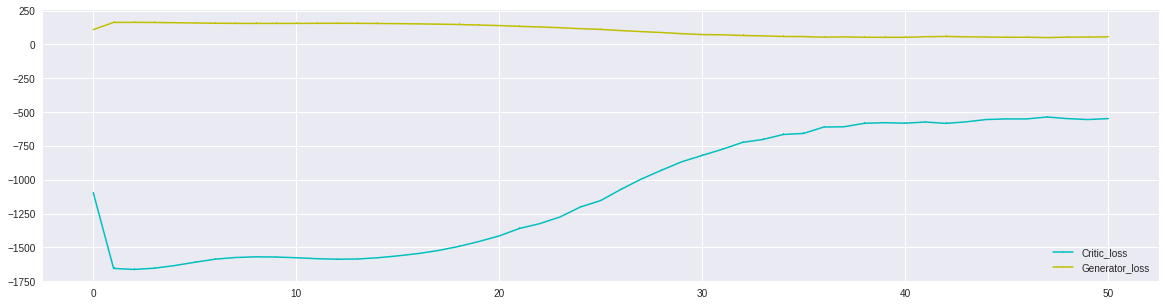

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(df[col[0]],df[col[1]],'-,c',label='Critic_loss', linewidth=1.5)
plt.plot(df[col[0]],df[col[2]],'-,y',label='Generator_loss', linewidth=1.5)
plt.legend()
plt.show()
plt.close()

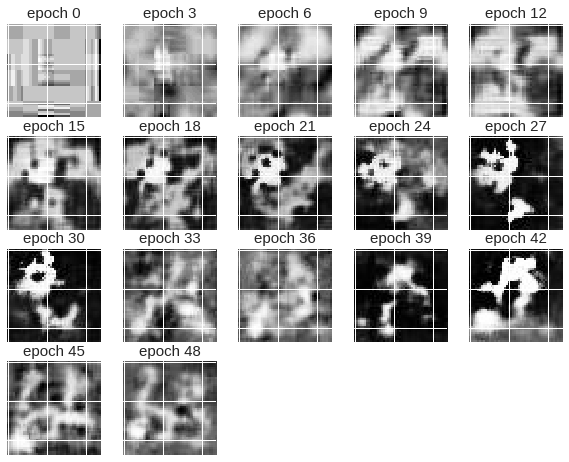

In [13]:
epoch_num = list(range(0,51,3)) 
plt.figure(figsize=(10,10))
for i,epoch in enumerate(epoch_num):
    img = np.array(Image.open('wgan_gen_progress_images/generate_img_epoch{0}_0.jpg'.format(epoch),'r').convert('L'))
    # train data plot
    plt.subplot(5, 5, i+1)
    plt.title('epoch {0}'.format(epoch),fontsize=15)
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.imshow(img)

plt.show()